# Exploration of High Scoring Affairs
In soccer analytics there are many results considered.  Because coaching is also interested in patterns in the game, the hidden truths in the data, a question was posed regarding high scoring games.  Is there a pattern which these games fall into, where defense is thrown out the window and goals come in high numbers.  Soccer/Football is for all intents and purposes a low scoring game. The introduction of the 3 point win was a huge shift in teams pursuing wins and not draws.  Even so, two to three goals is a pretty common outcome for a match.

What about the exceptions?  Not the one sided exceptions.  The track meets where the last team with the ball might be the winner.  The games where goals come fast and furious, but no team has a significant advantage.  Score lines like 4-3 or 5-5 come to mind.  Games with at least six goals which are well distributed.  Is there anything to learn from these *High Scoring Affairs*?

---

### Players and Coaches
As a player and a coach, it is assumed that high scoring games mean more time up the pitch, more aggressive and exposed play.  The assumption is that the average player position across a number of games in this category would show players in the oppositions side of the pitch more often.  Even so, that would mean more time for the opposition in defense.  Perhaps the games are about faster possessions which go uninterupted, and teams are able to progress to shooting positions more often.  How can event data to be used to learn more about the way such games are played?

### Finding HSAs
Polling competitions from the StatsBomb data, the goal will be to look through the history of information for HSA which have event data, and analyze the patterns associated with HSAs.  Using the Statsbomb parser, a query of the game results for competitions will be made and high scoring low differential games will be extracted so the event data can be analyzed.

In [1]:
import pandas as pd
import numpy as np

# importing SBopen from mplsoccer library to open the match data
# mplsoccer is leveraging a statsbomb library dependancy for this feature
from mplsoccer import Sbopen

# Instantiate a data parser
parser = Sbopen()

# competitions, seasons and match data available
df_comps = parser.competition()

In [2]:
df_comps.info() # 71 available competitions across years and leagues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             71 non-null     int64 
 1   season_id                  71 non-null     int64 
 2   country_name               71 non-null     object
 3   competition_name           71 non-null     object
 4   competition_gender         71 non-null     object
 5   competition_youth          71 non-null     bool  
 6   competition_international  71 non-null     bool  
 7   season_name                71 non-null     object
 8   match_updated              71 non-null     object
 9   match_updated_360          54 non-null     object
 10  match_available_360        8 non-null      object
 11  match_available            71 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 5.8+ KB


In [3]:
# Using chaining methods from Matt Harrison
(df_comps
 .assign(comp_seas = lambda df: df.competition_id.astype('str')+'-'+ df.season_id.astype('str'))
#  .head()
 .comp_seas
 .sort_values()
)

39      11-1
40      11-2
47     11-21
46     11-22
45     11-23
       ...  
54     81-48
21    87-268
22    87-279
20     87-84
0       9-27
Name: comp_seas, Length: 71, dtype: object

### Switching to StatsBomb library
MPLSoccer has a bug associated with the parser configuration.  Switching over the Statsbomb to pull the data for analysis.  The import and API process is shown below.

In [4]:
from statsbombpy import sb
# suppress due to free data warning
import warnings
warnings.filterwarnings('ignore')

In [5]:
sb.competitions(creds={'user': None, 'passwd': None}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             71 non-null     int64 
 1   season_id                  71 non-null     int64 
 2   country_name               71 non-null     object
 3   competition_name           71 non-null     object
 4   competition_gender         71 non-null     object
 5   competition_youth          71 non-null     bool  
 6   competition_international  71 non-null     bool  
 7   season_name                71 non-null     object
 8   match_updated              71 non-null     object
 9   match_updated_360          54 non-null     object
 10  match_available_360        8 non-null      object
 11  match_available            71 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 5.8+ KB


>**NOTE**:Just as seen previously, there are 71 competition records available through the StatsBomb free data sources.

In [6]:
# Break down on total seasons by competition name
(sb.competitions(creds={'user': None, 'passwd': None})
 .competition_name.value_counts()
 .rename('Seasons')
)

competition_name
Champions League           18
La Liga                    18
FIFA World Cup              8
Ligue 1                     3
Copa del Rey                3
FA Women's Super League     3
Liga Profesional            2
Serie A                     2
Premier League              2
Women's World Cup           2
African Cup of Nations      1
Major League Soccer         1
North American League       1
NWSL                        1
Indian Super league         1
FIFA U20 World Cup          1
UEFA Euro                   1
UEFA Europa League          1
UEFA Women's Euro           1
1. Bundesliga               1
Name: Seasons, dtype: int64

### Season Evaluator Function
Define a function to extract match ids from each season which meet criteria for HSA with low differential.  First, an inspection of the match data must be made to understand how the verifications can be conducted of the results.

In [7]:
sb.matches(11,1).iloc[0] # characteristic record

match_id                                       9880
match_date                               2018-04-14
kick_off                               16:15:00.000
competition                         Spain - La Liga
season                                    2017/2018
home_team                                 Barcelona
away_team                                  Valencia
home_score                                        2
away_score                                        1
match_status                              available
match_status_360                          scheduled
last_updated             2023-02-08T17:23:53.901920
last_updated_360            2021-06-13T16:17:31.694
match_week                                       32
competition_stage                    Regular Season
stadium                            Spotify Camp Nou
referee                     Carlos del Cerro Grande
home_managers              Ernesto Valverde Tejedor
away_managers                Marcelino García Toral
data_version

### Record Inspection
The match_id along with the home and away score can be inspected from the data which is available.  A column will need to be added for the total match goals and total differential, and finally a binary for HSA classification.  This can then be used to add match_ids to a dataframe/list for extraction of event data.

In [8]:
def hsa_add(df, goals=4, diff=3):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==1')
    return df_update

In [9]:
# function test
hsa_add(sb.matches(11,1))

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version,total_goals,goal_diff,HSA
1,9912,2018-04-29,20:45:00.000,Spain - La Liga,2017/2018,RC Deportivo La Coruña,Barcelona,2,4,available,...,Estadio Abanca-Riazor,Ricardo De Burgos Bengoetxea,Clarence Seedorf,Ernesto Valverde Tejedor,1.1.0,2,2,6,2,1
34,9754,2018-01-14,20:45:00.000,Spain - La Liga,2017/2018,Real Sociedad,Barcelona,2,4,available,...,Reale Arena,José Luis González González,Eusebio Sacristán Mena,Ernesto Valverde Tejedor,1.1.0,2,None,6,2,1


### Extract Competitions and Seasons
Extract all competitions and seasons, then extract and append all of the HSA games into a single database so the match_ids can be pull and the event data can be evaluated. 

In [10]:
def extract_comps(df):
    '''Extract a list of tuples for compeition and season ids.'''
    L = []
    for ind, row in (df.iterrows()):
        L.append((row.competition_id, row.season_id))
    return L

In [11]:
hsa_df = pd.DataFrame()
for i in extract_comps(sb.competitions()):
    hsa_df= pd.concat([hsa_df,hsa_add(sb.matches(i[0],i[1]),5,3)])

In [12]:
hsa_matches = hsa_df.reset_index().match_id.values

In [13]:
len(hsa_matches)

110

### Total Matches
In total, there are 110 matches across the entire dataset of competitions in the Statsbomb free datasets.  Without having inspected the specifics, that feels about right.  It wouldn't do to have thousands of matches in this category.  More often, soccer is a low scoring game.  Achieving more than 5 goals with a difference of less than 3 is an uncommon result.

>**NOTE**: Extracting event data

In [14]:
pd.set_option('display.max_rows', 500)

In [18]:
sb.events(hsa_matches[0]).type.unique() # lots of data to use

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Miscontrol', 'Shot', 'Goal Keeper', 'Duel',
       'Clearance', 'Ball Recovery', 'Block', 'Foul Committed',
       'Foul Won', 'Interception', 'Dispossessed', 'Dribble',
       'Dribbled Past', 'Injury Stoppage', 'Referee Ball-Drop',
       'Half End', 'Substitution', 'Tactical Shift', 'Bad Behaviour',
       'Shield'], dtype=object)

### Aggregating Options
The data include many different options to aggregate.  The question is why are these games different.  It may require analysis of some of the regular more typical score lines for comparison.  Initially the goal will be to characterize the games to determine if there is some indicators of a more offensive and open game.  Some characteristics to test:
- Shots: evaluate statistical data for shooting
    - Average and median amounts
    - Average and median position of occurance
    - Frequency across time (density question)
- Passing: evaluating what passing looks like in these games may also provide some insight
    - Distance evaluation
    - Average and median amounts
    - Chain associated with goals (long short passing chains?  How many before scoring on average)
    - Passing network shape across all games?  Some games? by game?

The story may vary by game, or there might be some things which are consistent.  Sometimes it may be an element of the two teams being each others weakness, leading to the open game.  At other times it might be related to the style teams play across all the games. 

In [19]:
# defining universal event extractor function
def event_extract(match_ids, type_id):
    '''Returns all events matching the specified type using the statsbomb library.
    matchid = number or array of numbers containing matchid
    type = event type, for example: 'Pass', 'Ball Receipt*', 'Carry',
       'Shot', 'Goal Keeper', 'Duel', 'Clearance', 'Ball Recovery', 'Block', 'Foul Committed'
    '''
    type_df = pd.DataFrame()
    for i in match_ids:
        type_df = pd.concat([sb.events(i).query("type==@type_id"),type_df])
    return type_df

In [21]:
shots_df = event_extract(hsa_matches,type_id='Shot')

In [50]:
shots_fin_df = (shots_df
 .dropna(axis=1, how='all')
 .assign(x = lambda df: df.location.apply(lambda x: x[0]),
         y = lambda df: df.location.apply(lambda x: x[1]),
         time = lambda df: pd.to_timedelta(df.timestamp))
)

In [51]:
(shots_fin_df
 .type
 .value_counts()
)

type
Shot    3190
Name: count, dtype: int64

### Plotting Shots
With all 3000+ shot events in a dataframe, a plot of the shot locations across all the games should provide some be helpful as a first evaluation of the data.  An effort will not be made to correct team directions.  All shots will be plots at the location on which they are recorded, meaning everything will be on one end of the field.  This should not impact visual since it will keep eveything on the same view.  

---

In [56]:
import mplsoccer as mpl
import matplotlib.pyplot as plt
import seaborn as sns

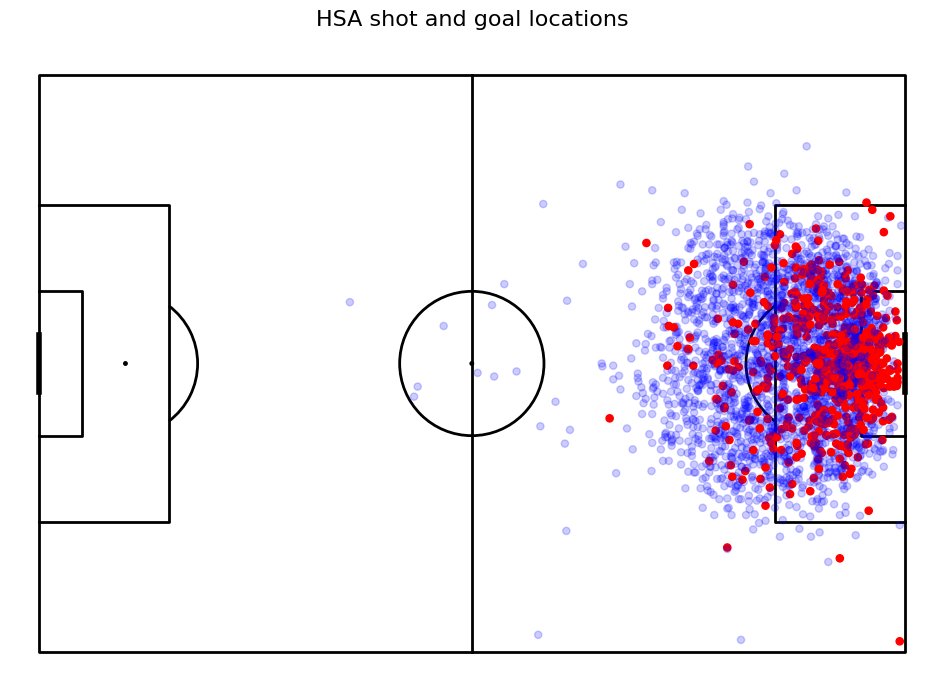

In [52]:
pitch = mpl.Pitch(line_color = "black")
fig, ax = pitch.draw(figsize=(10, 7))
#Size of the pitch in yards (!!!)
pitchLengthX = 120
pitchWidthY = 80
for i,shot in shots_fin_df.iterrows():
    #get the information
    x=shot.location[0]
    y=shot.location[1]
    goal=shot['shot_outcome']=='Goal'
    #set circlesize
    circleSize=0.5
    #plot goal
    if goal:
        shotCircle=plt.Circle((x,y),circleSize,color="red")
        # plt.text(x+1,y-2,shot['player_name'])
    else:
        shotCircle=plt.Circle((x,y),circleSize,color="blue")
        shotCircle.set_alpha(.2)
    ax.add_patch(shotCircle)
#set title
fig.suptitle("HSA shot and goal locations", fontsize = 16)
fig.set_size_inches(10, 7)
plt.show()

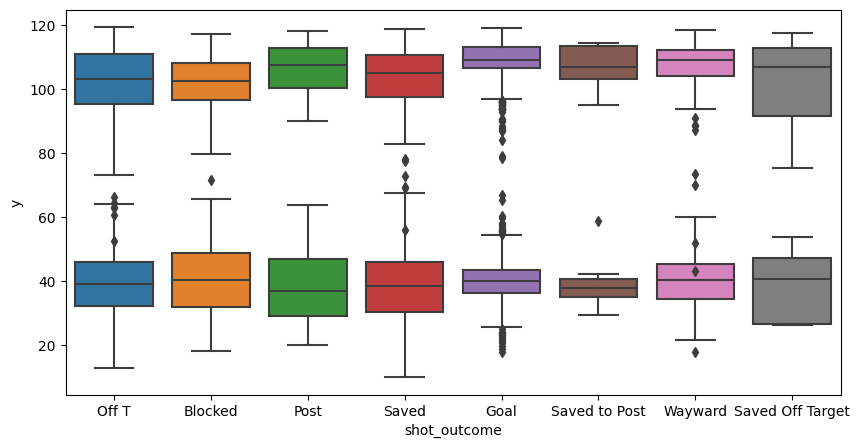

In [59]:
fig,ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=shots_fin_df,x='shot_outcome',y='x')
sns.boxplot(data=shots_fin_df,x='shot_outcome',y='y')

plt.show()

### Findings
Nothing to surprising.  Most of the shots come from the magic section of the field in front of the goal and inside or just at the edge of the box.  To evaluate the result in this view all of the other games from the original data set would need to be plotted seperately do determine if there was anything different associated with the shot location information. Perhaps it would be good to determine the total number of shots per game, and other similar concepts game by game.